In [141]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests as rs
from PIL import Image
import pytesseract
from pytesseract import image_to_string 
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
import cv2
import time
# 清理資料用
import pandas as pd 
import numpy as np

# 爬蟲用
import requests,json
import urllib.parse
import ssl #給對方知道連線安全
from bs4 import BeautifulSoup as bs
from time import sleep #每跑一下休息
from requests.adapters import HTTPAdapter #安全網域
from requests.packages.urllib3.util.retry import Retry  #對方擋住爬蟲 所以要一直重複跑
from selenium import webdriver #控制網頁機器人

In [142]:
pytesseract.pytesseract.tesseract_cmd =(r'/Users/julia/Desktop/海量研究室/tesseract')

# 驗證碼圖片處理

In [143]:
def removeFrame(img, width):
    '''
    :param img:
    :param width: 邊框的寬度
    :return;
    '''
    w, h = img.size
    pixdata = img.load()
    for x in range(width):
        for y in range(0, h):
            pixdata[x, y] = 255
    for x in range(w - width, w):
        for y in range(0, h):
            pixdata[x, y] = 255
    for x in range(0, w):
        for y in range(0, width):
            pixdata[x, y] = 255
    for x in range(0, w):
        for y in range(h - width, h):
            pixdata[x, y] = 255
    return img


def calculate_noise_count(img_obj, w, h):
    """
    計算領域非白色的個數
    Args:
        img_obj: img obj
        w: width
        h: height
    Returns:
        count (int)
    """
    count = 0
    width, height,s = img_obj.shape
    for _w_ in [w - 1, w, w + 1]:
        for _h_ in [h - 1, h, h + 1]:
            if _w_ > width - 1:
                continue
            if _h_ > height - 1:
                continue
            if _w_ == w and _h_ == h:
                continue
            if (img_obj[_w_, _h_,0] < 233) or (img_obj[_w_, _h_,1] < 233) or (img_obj[_w_, _h_,2] < 233):
                count += 1
    return count

def noise_unsome_piexl(img):
    '''
        查找像素素點相鄰的顏色，如果是非白色的則填充為白色
    :param img:
    :return:
    '''
    # print(img.shape)
    w, h, s = img.shape
    for _w in range(w):
        for _h in range(h):
            if _h != 0 and _w != 0 and _w < w - 1 and _h < h - 1:
                center_color = img[_w, _h] 
                # print(center_color)
                top_color = img[_w, _h + 1]  
                bottom_color = img[_w, _h - 1] 
                left_color = img[_w - 1, _h]  
                right_color = img[_w + 1, _h]  
                cnt = 0
                if all(top_color == center_color):
                    cnt += 1
                if all(bottom_color == center_color):
                    cnt += 1
                if all(left_color == center_color):
                    cnt += 1
                if all(right_color == center_color):
                    cnt += 1
                if cnt < 1:
                    img.itemset((_w, _h, 0), 255)
                    img.itemset((_w, _h, 1), 255)
                    img.itemset((_w, _h, 2), 255)
    return img
def operate_img(img,k):
    w,h,s = img.shape
  
    for _w in range(w):
       
        for _h in range(h):
            if _h != 0 and _w != 0 and _w < w-1 and _h < h-1:
                if calculate_noise_count(img, _w, _h) < k:
                    img.itemset((_w,_h,0),255)
                    img.itemset((_w, _h,1), 255)
                    img.itemset((_w, _h,2), 255)

    return img

# 統整執行

In [144]:
#圖片處理
def img_find(img): 
    img=removeFrame(img,2)  #去除邊匡
    
    ret, img2 = cv2.threshold(np.float32(img), 160, 255, cv2.THRESH_BINARY)  #處理圖降噪程度
    plt.subplot(121), plt.imshow(img)  # 原始圖片
    plt.subplot(122), plt.imshow(img2)  # 降噪圖片
    
    img2 = operate_img(img2, 4)
    img2 = operate_img(img2, 4)
    img2 = operate_img(img2, 4)
    img_new=Image.fromarray(np.uint8(img2)) # array轉圖片
    return img_new


#圖片轉文字
def text_show(img_new): 
    text=pytesseract.image_to_string(img_new,config ='--psm 7')  
    text= text.strip()
    text = text.replace(' ', '')
    text = text.replace('\n', '')
    return text

#輸入驗證碼
def send_keys(text):
    driver.find_element_by_id('captcha').send_keys(text)  
    driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/form[1]/div/table/tbody/tr[3]/td/div/div[1]/input').click()
    try:
        driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/div[5]/table[1]/tbody[11]/tr/td[1]/input')
        r='驗證碼正確'
    except :
        r='驗證碼錯誤'
        image = driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/form[1]/div/table/tbody/tr[2]/td/div[1]/div/div[1]/div/img').screenshot("screenshot.png")
        sleep(1)
        img = Image.open('screenshot.png') ##打開圖片
        img_new_cor=img_find(img)
        text_cor=text_show(img_new_cor)
        driver.find_element_by_id('vatId').send_keys(keys)
        sleep(1)
        send_keys(text_cor)
    return r


def forward_step(r):
    try:
        driver.find_element_by_id('operatingStatus').click()
        sleep(2)
        driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/div[5]/table[1]/tbody[2]/tr/td/select/option[2]').click()
        sleep(3)
        e='此公司有分支機構' 
    except:
        e='此公司無分支機構'
    return e   

def head_office(h):
    try:
        driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/div[5]/table[1]/tbody[2]/tr/td/input').click()
        sleep(3)
        h='此公司有總機構'
    except:
        h='此公司無總機構'
    return h
#建立主表格
def build_form(e,h):
   
    element = driver.find_element_by_id('txCompany')
    driver.execute_script("arguments[0].click();", element)

     #是否使用統一發票行
    sleep(3)
  
    etax=bs(driver.page_source)
    table = etax.find('table', {'class': 'table table-bordered'})
    columns = [th.text.replace('\n', '') for th in table.find_all('th')]
    
    trs = table.find_all('tr')[1:]
    
    rows = list()
    for tr in trs:
        rows.append([td.text.replace('\n', '') for td in tr.find_all('td')])
    data_new=[]
    for i in rows:
        if i!=[]:
            data_new.append(i)

    all=[]
    for i in data_new:
        for j in i:
            all.append(j)
    del all[-2]
    df = pd.DataFrame(all,columns)
    df=df.T
    str1 = ''.join(df['登記營業項目'].values)
    str2 = "有關營業登記資料記載內容"
    extract_value=str1[:str1.index(str2)]
    df['登記營業項目']=extract_value
    
    df.loc[df['是否使用統一發票行號查詢(以最近3期完成統一發票申報作業的公司行號為限)'] == '有使用統一發票', '是否使用統一發票行號查詢(以最近3期完成統一發票申報作業的公司行號為限)'] = '有'
    df.loc[df['是否使用統一發票行號查詢(以最近3期完成統一發票申報作業的公司行號為限)'] == '無統一發票資訊', '是否使用統一發票行號查詢(以最近3期完成統一發票申報作業的公司行號為限)'] = '無'
    
    df=df.drop(['查看分支機構：'], axis=1)
    
    if e =='此公司有分支機構':
        table1= etax.find('table',{'class':'table','id':'etw113wInfoList'})
        columns_other = [th.text.replace('\n', '') for th in table1.find_all('th')]
        columns_other

        trs1 = table1.find_all('tr')[1:]
        rows1 = list()
        for tr in trs1:
            rows1.append([td.text.replace('\n', '') for td in tr.find_all('td')])
        del rows1[0]
        
        other_num=[]
        for i in rows1:
            other_num.append(i[1]) #其他分支機構list
        list_other = ['/ '.join(other_num)]
        
        df['其他分支機構']=list_other
        
    else:
        other_num=[]
        df['其他分支機構']=None
    
    if h=='此公司有總機構':
        table2= etax.find('table',{'class':'table','id':'etw113wInfoList'})
        columns_other2 = [th.text.replace('\n', '') for th in table2.find_all('th')]
        columns_other2

        trs2 = table2.find_all('tr')[1:]
        rows2 = list()
        for tr in trs2:
            rows2.append([td.text.replace('\n', '') for td in tr.find_all('td')])
        del rows2[0]
        head_num=[]
        for i in rows2:
            head_num.append(i[1])
        list_head = ['/ '.join(head_num)]
        df['營業總機構']=list_head
    else:
        head_num=[]
        df['營業總機構']=None
    return df,other_num,head_num
    

In [145]:
import csv
with open('/Users/julia/Desktop/統一編號.csv','r',encoding= 'unicode_escape') as f:
    reader = csv.reader(f)
    next(reader) #skip header
    num=[]
    for row in reader:
        for i in row:
            num.append(i)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-144-091b5ac6b665>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121), plt.imshow(img)  # 原始圖片
<ipython-input-144-091b5ac6b665>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122), plt.imshow(img2)  # 降噪圖片
Clipping input data to the valid range for imshow with RGB data ([0..1] f

135.0905261039734


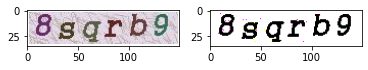

In [148]:
df_all = pd.DataFrame([])
start=time.time()
for i in num:
    url = 'https://www.etax.nat.gov.tw/cbes/web/CBES113W1_1'
    driver = webdriver.Chrome(r'/Users/julia/Desktop/海量研究室/chromedriver')
    driver.get(url)
    driver.maximize_window()
    sleep(2)
    image = driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/form[1]/div/table/tbody/tr[2]/td/div[1]/div/div[1]/div/img').screenshot("screenshot.png")
    sleep(1)
    img = Image.open('screenshot.png') ##打開圖片
    img_new=img_find(img)

    text=text_show(img_new)

    keys=i

    driver.find_element_by_id('vatId').send_keys(keys)
    cor=send_keys(text)
    sleep(3)
    bul=forward_step(cor)
    sleep(3)
    head=head_office(cor)
    sleep(3)

    
    df_append,other_list,head_list=build_form(bul,head)
    driver.quit()
    df_all=df_all.append(df_append)
    for w in other_list:
        if w not in num:
            num.append(w)
    for y in head_list:
        if y not in num:
                num.append(y)
end=time.time()
print(end-start)

In [149]:
df_all.index = range(len(df_all))

In [150]:
df_all

,營業人統一編號,營業狀況,負責人姓名,營業人名稱,營業（稅籍）登記地址,資本額(元),組織種類,設立日期,登記營業項目,是否使用統一發票行號查詢(以最近3期完成統一發票申報作業的公司行號為限),其他分支機構,營業總機構
0,23225229,營業中,林寶水,長榮航空股份有限公司,桃園市蘆竹區南崁里新南路１段３７６號,"48,535,694,900",股份有限公司( 1 ),0780407,航空運輸( 510000 ) ...,有,25977076/ 89282782/ 93954298,None
1,80115665,營業中,余秀玲,聯發科研有限公司,高雄市前鎮區竹南里鄭和南路４２６號９樓之１,"1,000,000",有限公司( 2 ),0920127,電子及半導體生產用機械設備製造( 292800 ) ...,有,None,None
2,25977076,營業中,孫嘉明,長榮航空股份有限公司高雄辦事處,高雄市苓雅區苓東里四維四路１７７號１樓,0,其他( 0 ),0990804,航空運輸( 510000 ) ...,有,None,23225229
3,89282782,營業中,孫嘉明,長榮航空股份有限公司台北分公司,臺北市中山區朱園里長安東路２段１１７號,0,本國公司設立之分公司( 9 ),0830930,航空運輸( 510000 ) ...,有,None,23225229
4,93954298,非營業中,連維煌,長榮航空股份有限公司高雄辦事處,高雄市苓雅區苓東里四維四路１７７號１樓,0,其他( 0 ),0840609,航空運輸( 510000 ) ...,無,None,23225229


In [151]:
df_all.to_csv('/Users/julia/Desktop/海量研究室/財政部.csv',index=False)